In [14]:
import pandas as pd

In [2]:
# need to change results to structured array
# True means dead
# False means alive 


from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [11]:
# right censored as more people died during the study 

len([x[0] for x in data_y if x[0] == True])

128

In [12]:
len([x[0] for x in data_y if x[0] == False])

9

In [18]:
pd.DataFrame(data_y).head(20)

,Status,Survival_in_days
0,True,72.0
1,True,411.0
2,True,228.0
3,True,126.0
4,True,118.0
5,True,10.0
6,True,82.0
7,True,110.0
8,True,314.0
9,False,100.0


# Survival Function

![SurvivalFunction](Survival_Function.png)

In [16]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


For t =  11, we can see that before t = 11, there are 2 people confirmed dead, hence S(t = 8) = 3/5 who are known to be alive at the point of time 

for t = 30, we cannot  determine that person #4 is still alive or dead at t = 30 because last read data was at t = 25. 

# Kaplan-Meier Estimator

Text(0.5, 0, 'time $t$')

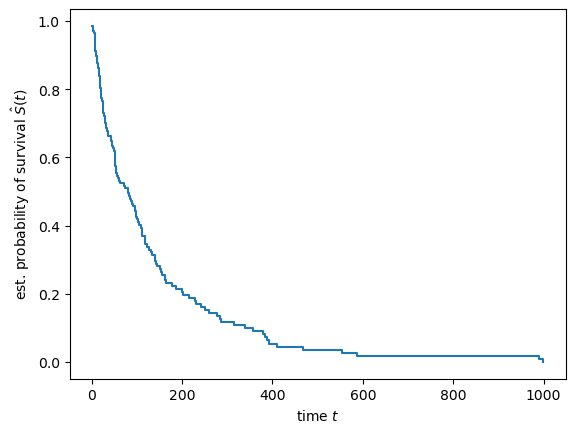

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

#  Considering other variables by stratification



## Survival functions by treatment 

In [27]:
data_x['Treatment'].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

`Is there any difference in survival between the two treatment groups?`

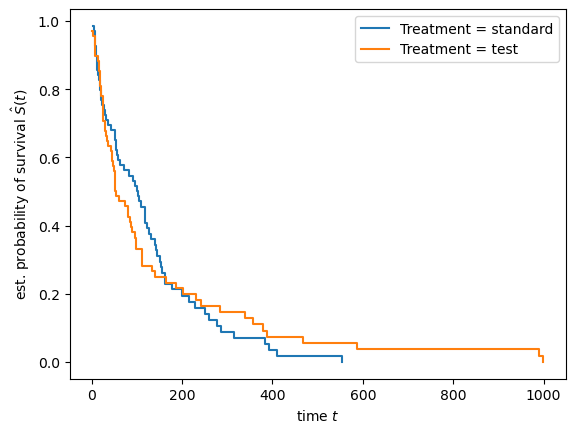

In [28]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Survival functions by cell type

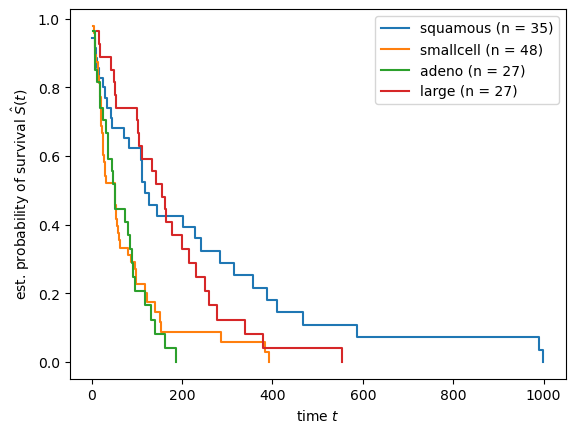

In [52]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [53]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


## Cox PH model

In [54]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [55]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [59]:
# creating 4 separate patients
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


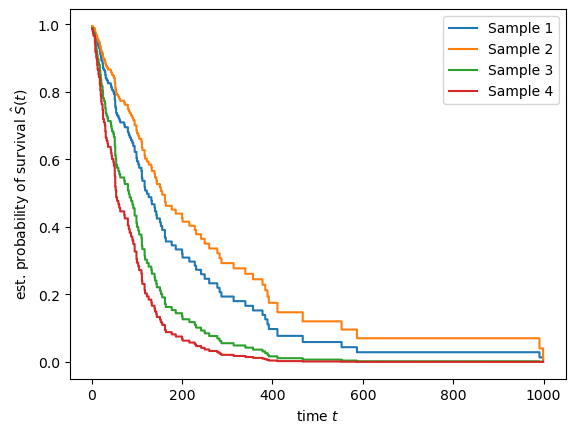

In [58]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Measuring the Performance of Survival Models

In [60]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

In [61]:
estimator.score(data_x_numeric, data_y)

0.7362562471603816

# Feature Selection: Which Variable is Most Predictive?

In [62]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [64]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a fu

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


In [65]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

c:\Users\User\anaconda3\envs\surv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64